# Calibration

## 1. Detect chessboard corners in the images

### 1.0 Load Images

In [31]:
%matplotlib notebook

from openalea.phenomenal.data import plant_1_images_chessboard
from openalea.phenomenal.display import show_images, show_image

chessboard_image = plant_1_images_chessboard()

<IPython.core.display.Javascript object>


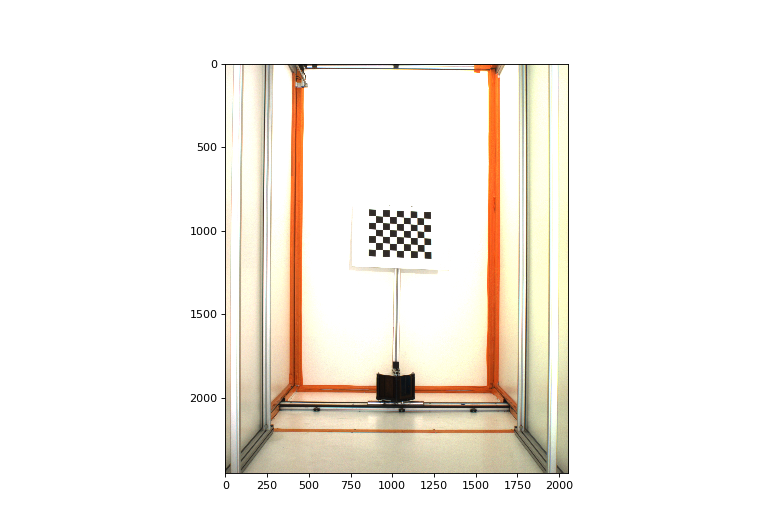

In [32]:
show_image(chessboard_image['side'][42])

### 1.1 Create chessboard object

Create chessboard object with square size and shape of chessboard

In [33]:
from openalea.phenomenal.calibration.chessboard import Chessboard

square_size_of_chessboard = 47 # In mm
square_shape_of_chessboard = (8, 6) # (8 square x 6 square on chessboard)

# BUILD CHESSBOARD OBJECT
chessboard = Chessboard(square_size_of_chessboard, 
                        square_shape_of_chessboard)

# DISPLAY IT
print chessboard

Chessboard Attributes :
Square size (mm): 47
Shape : (8, 6)



### 1.2 Detect corners from images

In [34]:
from cv2 import imread, IMREAD_GRAYSCALE, imwrite

for id_camera in chessboard_image:
    for angle in chessboard_image[id_camera]:
        im = chessboard_image[id_camera][angle]
        found = chessboard.detect_corners(id_camera, angle, im)
        print("Angle {} - Chessboard corners {}".format(angle, "found" if found else "not found"))

Angle 42 - Chessboard corners found


### 1.3 Display chessboard corners on images

<IPython.core.display.Javascript object>


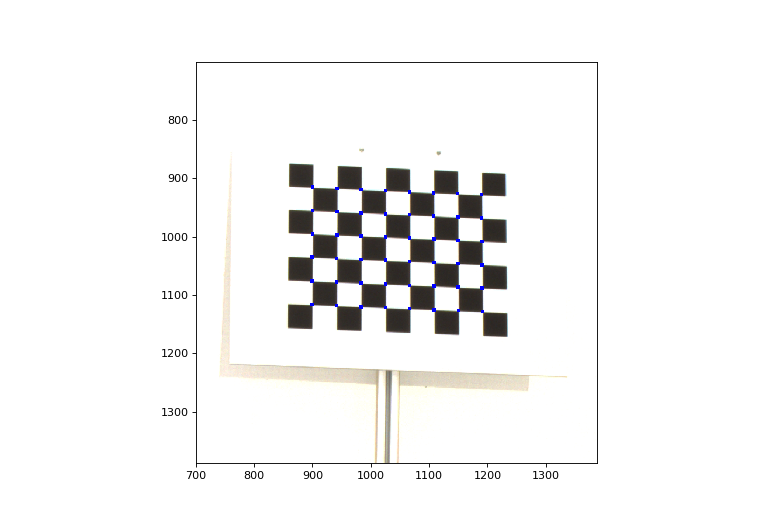

In [35]:
def show_detected_corner(id_camera, angle):
    
    img = chessboard_image[id_camera][angle].copy()

    # DRAW RED POINT ON IMAGE CORNERS POSITION
    points_2d = chessboard.image_points[id_camera][angle].astype(int)
    k_neighbors = 3
    for x, y in zip(points_2d[:, 0, 1], points_2d[:, 0, 0]):
        img[x-k_neighbors:x+k_neighbors, y-k_neighbors:y+k_neighbors] = [0, 0, 255]

    show_image(img)
    
show_detected_corner("side", 42)

### 2.4 Dump & load

In [36]:
chessboard.dump('chessboard')
chessboard = Chessboard.load('chessboard')

## 2. Multi-camera calibration

### 2.0 Load chessboard object with all corners points

In [37]:
from openalea.phenomenal.data.plant_1 import plant_1_chessboards

# Load chessboard object
chess_1, chess_2 = plant_1_chessboards()


id_camera = "side"
for angle in range(0, 360, 3):
    if (not angle % 30 == 0) and angle != 42:
        chess_1.image_points[id_camera].pop(angle, None)
        chess_2.image_points[id_camera].pop(angle, None)

### 2.1 Do calibration

In [43]:
from openalea.phenomenal.calibration import (
    CalibrationCameraSideWith2TargetYXZ)

# Define size image of image chessboard to calibrate
size_image = (2056, 2454)

# Calibrate
id_camera = "side"
calibration = CalibrationCameraSideWith2TargetYXZ()
err = calibration.calibrate(chess_1.get_corners_2d(id_camera), 
                            chess_1.get_corners_local_3d(),
                            chess_2.get_corners_2d(id_camera), 
                            chess_2.get_corners_local_3d(),
                            size_image,
                            number_of_repetition=0,
                            verbose=False)

# Error of reprojection (in pixel distance) for all point in the target (48)
# So real error is err / 48
print err

6.06983505043


### 2.2 Dump & load

In [40]:
# Dump
calibration.dump('calibration_camera_side')

In [41]:
from openalea.phenomenal.calibration.calibration import CalibrationCameraSideWith2Target

# Load 
calibration = CalibrationCameraSideWith2Target.load('calibration_camera_side')

### 2.6 Viewing calibration result

#### 2.6.2 Show chessboard image with corners projection

<IPython.core.display.Javascript object>


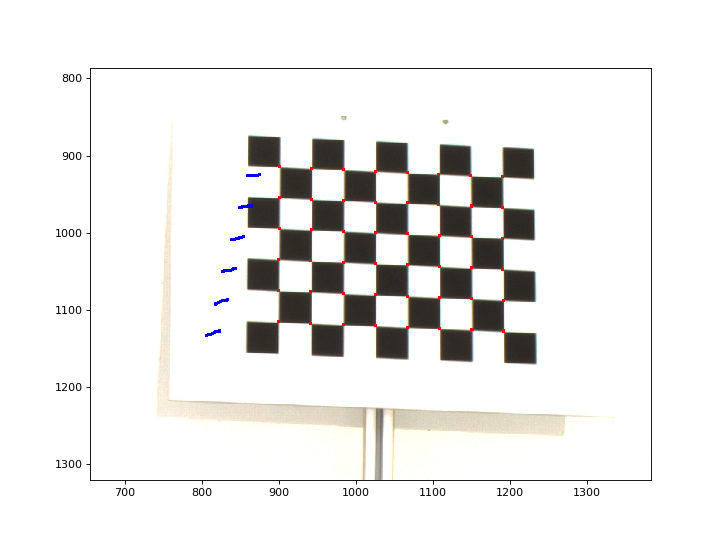

In [42]:
%matplotlib notebook

import matplotlib.pyplot
from openalea.phenomenal.image import read_image
from openalea.phenomenal.display import show_image

import cv2
# from alinea.phenomenal.display.image import 

angle = 42

def show_detected_and_projected_corner(id_camera, angle, k=2):

    img = chessboard_image[id_camera][angle].copy()

    # RED POINTS ARE POINTS POSITIONS DETECTED BY OPENCV CHESSBOARD DETECTION 
    pt_2d = chess_1.image_points["side"][angle].astype(int)

    for x, y in zip(pt_2d[:, 0, 1], pt_2d[:, 0, 0]):
        img[x-k:x+k, y-k:y+k] = [255, 0, 0]

    # BLUE POINTS ARE POINTS POSITIONS PROJECTED BY CALIBRATION CHESSBOARD COMPUTATION
    points_2d = calibration.get_target_1_projected(angle, chess_1.get_corners_local_3d())
    for x, y in map(lambda x : map(int, tuple(x)), points_2d):    
        img[y-k:y+k, x-k:x+k] = [0, 0, 255]

    show_image(img)
    
show_detected_and_projected_corner('side', 42)